In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [3]:
# DIR = "/content/drive/MyDrive/Clases/FCEN DM/datos/"
# df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
# df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

# Limpieza y transformación de datos (magia parte 2 -- MD)

In [4]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [5]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [6]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']


df_train.shape

(152720, 24)

## Imputación de nulos

In [7]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [8]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [10]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

In [12]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [13]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [14]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [15]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [16]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [17]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [18]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [19]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [20]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [21]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<Axes: xlabel='surface_covered'>

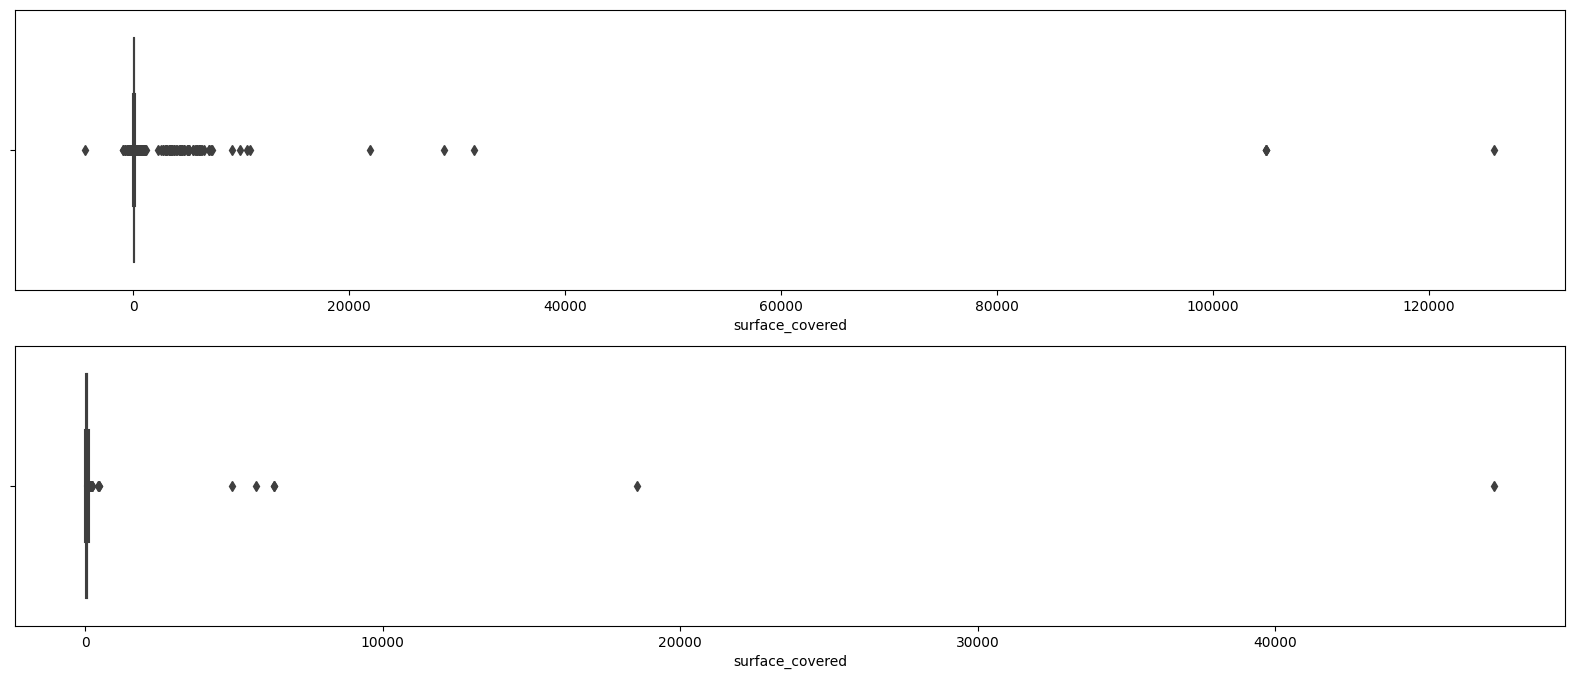

In [22]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [23]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [24]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [25]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<Axes: xlabel='surface_total'>

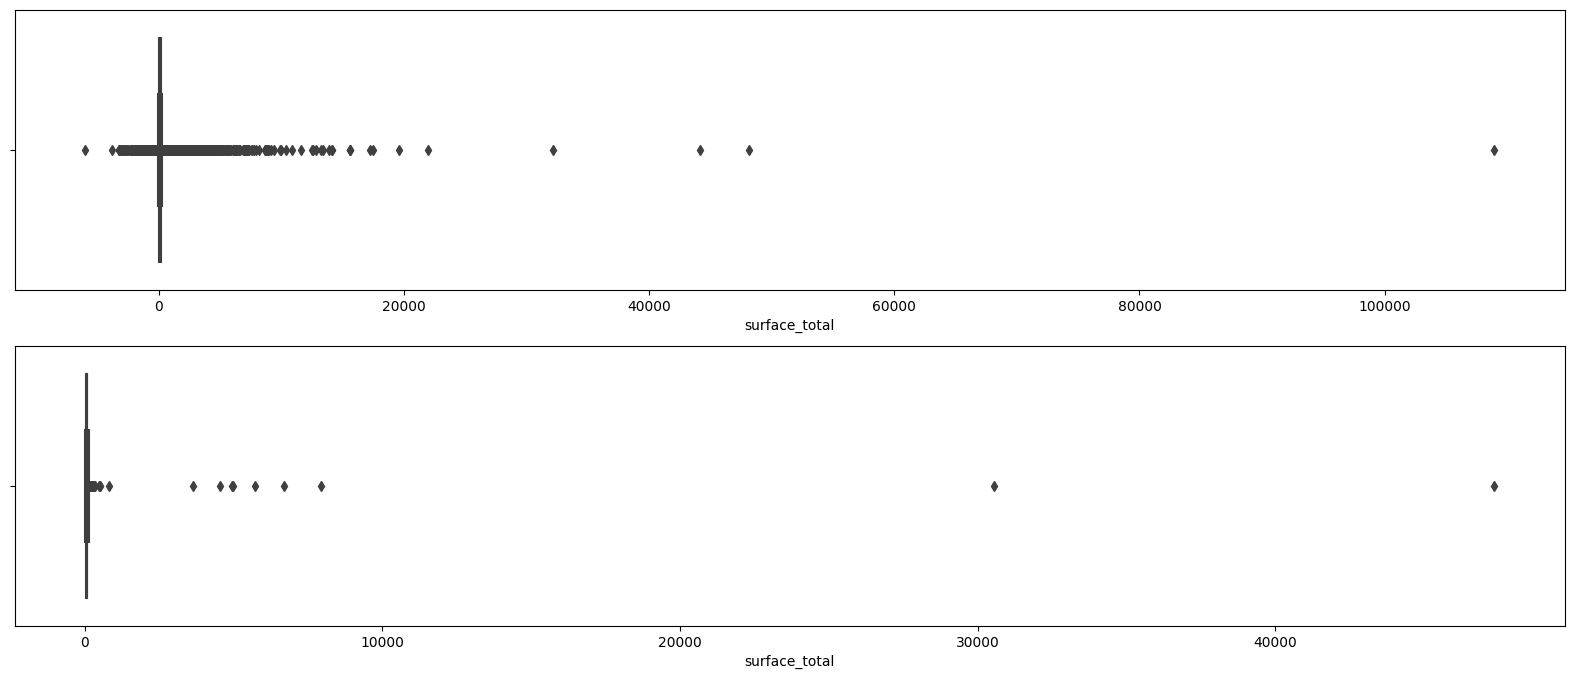

In [26]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [27]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [28]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [29]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [30]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [31]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [32]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Armado de variables

In [33]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

In [34]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [35]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [36]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19008\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19008\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [37]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [38]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [39]:
from sklearn.feature_selection import VarianceThreshold

In [40]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [41]:
F = df_train[~df_train.price.isnull()]
X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
y = F['price']

clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
clf.fit(X, y)

importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

cols.append('price')

df_train = df_train[cols]
df_test = df_test[cols]

In [42]:
importancias.sort_values('importancia')

,atributo,importancia
85,property_type_nan,0.000000e+00
13,lon_imputed,0.000000e+00
12,lat_imputed,0.000000e+00
19,l2_nan,0.000000e+00
30,l3_Catalinas,2.400890e-08
...,...,...
11,surface_covered_imputed,4.873727e-02
54,l3_Puerto Madero,6.067105e-02
0,lat,6.296073e-02
1,lon,1.813172e-01


In [43]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [44]:
# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [45]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=34611384081.1794 score_test=28834147727.468113
fold=1, score_train=34157352247.400597 score_test=38554916693.13111
fold=2, score_train=35542259759.044 score_test=22125592444.71847
fold=3, score_train=36082352568.81695 score_test=19123489268.018856
fold=4, score_train=35779040811.39829 score_test=20637331417.63484
fold=5, score_train=32266438842.778378 score_test=49546331809.44563
fold=6, score_train=34958480247.04564 score_test=29654430793.45299
fold=7, score_train=34551091655.491714 score_test=30631239871.07867
fold=8, score_train=34556574537.96807 score_test=34569566757.97371
fold=9, score_train=28927932999.51875 score_test=195517621267.3599
Train scores mean=34143290775.06417, std=2117027027.3922772
Test scores mean=46919466805.02822, std=52998288697.66887


# Predicción para kaggle


In [46]:
## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
df_test['price'].to_csv('solucion.csv', index=True)

In [47]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_*100), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False)

,column,feature_importance
0,surface_covered,56.468893
1,lon,10.756079
2,lat,9.750096
3,surface_covered_imputed,6.962417
5,bathrooms,5.371326
7,bathrooms_rooms,2.932176
4,surface_total,2.035990
8,bedrooms_imputed,1.818638
9,bedrooms,1.302491
6,covered,1.282137
